# Convolutional Neural Network

CNN, 畳み込みニューラルネットワーク {cite:ps}`2016-as`

![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/nkdkccmbr/20161006/20161006220128.png)  
CNNのイメージ 出典：[畳み込みニューラルネットワーク(CNN) -- ニューラルネットワーク・DeepLearningなどの画像素材　プレゼン・ゼミなどに【WTFPL】](https://nkdkccmbr.hateblo.jp/entry/2016/10/06/222245)

In [4]:
# packageのimport
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.std import trange,tqdm
import numpy as np 
import numpy.typing as npt
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from PIL import Image
import cv2
import requests

# pytorch関連のimport
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
SEED = 2023_6_27

In [5]:
from src import utils

utils.set_seed(SEED)

## CNNとは

### CNNの歴史

動物の視覚屋の神経細胞の二つの動き：

1. 画像の濃淡パターンを検出する機能
2. 物体の位置ズレを許容して同一物体だとみなす機能

を再現したモデルがCNNです．これを組み込んだ最初期のモデルはネオコグニトロン（Negcognitron）と呼ばれ，福島邦彦氏によって発表されました{cite:ps}`Fukushima1980-zv`．訓練は自己組織化によって行われます．

> ![](./figs/cnn/neocognitron2.png)  
> 出典：[視覚パターン認識とネオコグニトロン |福島邦彦](http://www.visionsociety.jp/vision/vol29-1/29-1_1.pdf)

現在主流のCNNはネオコグニトロンをベースに，訓練方法を誤差逆伝播法に変えられています．そしてその後にCNNは更に深層化し，様々な画像認識タスクで当時のSoTA（State-of-the-Art, 現時点での最先端レベルの性能）を叩き出しました．特に有名なのが2012年のILSVRC（ImageNet Large Scale Visual Recognition Challenge）という画像認識コンペティションでしょう．ここで[Geoffrey Everest Hinton](https://scholar.google.is/citations?user=JicYPdAAAAAJ)らのチームがAlexNetというCNNで，これまでの誤差率を10%以上を改善し，大成功を収めたのが有名です．{cite:ps}`Krizhevsky2012-nl`  

### 初期のCNNの有名なモデル

#### LeNet
基本的なCNNアーキテクチャのモデルです．

関係する論文：
- {cite:ps}`LeCun1989-us`
- {cite:ps}`Cun1990-yz`
- {cite:ps}`Lecun1998-im`


#### AlexNet
前述した通り，2012年のILSVRC（ImageNet Large Scale Visual Recognition Challenge）で優勝したモデル{cite:ps}`Krizhevsky2012-nl`．  
これまでの誤差率を10%以上を改善し，Deep Learningブームを引き起こしました．  

また，ImageNetという大規模画像データセット{cite:ps}`Deng2009-ei`自体の登場も，CNNの発展に大きく寄与しました．
#### VGG

2014年のILSVRCにおけるImageNetを用いた画像認識精度のコンペティションで画像分類部門で2位、物体のローカライゼーション部門で1位を記録したモデルです．{cite:ps}`Simonyan2014-wx`  
当時では大きな数である（Conv, MaxPool, Linearを合計して）16層のモデルです．


#### GoogLeNet

InceptionNetと名付けられたモデルの中の最初のバージョン，Inception v1はGoogLeNetとも呼ばれています．{cite:ps}`Szegedy2015-qi`  

> 複数の畳み込み層やpooling層から構成されるInceptionモジュールと呼ばれる小さなネットワーク (micro networks) を定義し，これを通常の畳み込み層のように重ねていくことで1つの大きなCNNを作り上げている点である．  
> 引用：[畳み込みニューラルネットワークの最新研究動向 (〜2017)](https://qiita.com/yu4u/items/7e93c454c9410c4b5427#googlenet-2014)

## 画像データ

### 画像データの配列

iris datasetは一つのデータが一次元配列で表現されていました．これに対してこれから扱う画像データは：
- 各ピクセルがグレースケールの色情報を持っている時，一つのデータは2次元配列として表現されます．
- 各ピクセルがRGBの色情報を持っている時，一つのデータは3次元配列として表現されます．

![](https://fgnt.github.io/python_crashkurs_doc/_images/numpy_array_t.png)  
出典：[Python Tutorial](https://fgnt.github.io/python_crashkurs_doc/include/numpy.html)

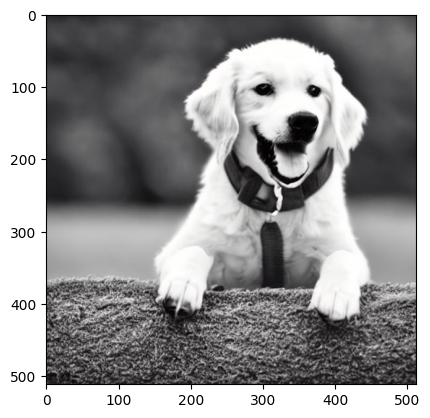

このようなグレースケールの画像ならば，二次元配列で表現することができます：
(512, 512)
[[40 40 40 ... 67 67 67]
 [42 42 41 ... 67 67 67]
 [44 44 43 ... 68 68 68]
 ...
 [74 80 75 ... 37 46 44]
 [62 74 74 ... 37 46 52]
 [58 67 74 ... 51 53 59]]


In [6]:
path = "./figs/cnn/stablediffusion_dog_grayscale.jpeg"
img = cv2.imread(path)
plt.imshow(img)
plt.show()
# 画像はgrayスケールで作成したはずですが，実際には3色持っているので配列を見せる時は変換しています．
print("このようなグレースケールの画像ならば，二次元配列で表現することができます：")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray_img.shape)
print(gray_img)

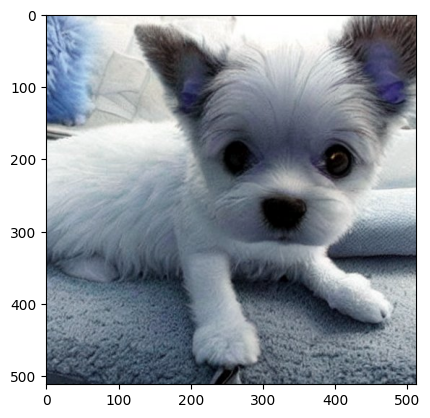

このようなカラー画像だとRGBの3チャネルが必要なので，三次元配列になります：
(512, 512, 3)
[[[118 146 181]
  [129 157 192]
  [129 156 193]
  ...
  [102  94  87]
  [108 100  93]
  [104  96  89]]

 [[113 141 176]
  [124 152 187]
  [126 153 190]
  ...
  [ 99  91  84]
  [100  92  85]
  [ 97  89  82]]]


In [7]:
path = "./figs/cnn/stablediffusion_dog.jpeg"
img = cv2.imread(path, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
print("このようなカラー画像だとRGBの3チャネルが必要なので，三次元配列になります：")
print(img.shape)
print(img[:2,:,:])

## CNNのアーキテクチャ

### 画像データのためのニューラルネットワーク

さて，MLPでは二次元配列の位置情報をうまく扱うことができませんので，仮にMLPにgrayスケールの画像を入力したいならば，一つのデータが一次元配列で表現されるようにshapeを変える必要があります．

In [8]:
print("オリジナル：", gray_img.shape)
print("変換後：", gray_img.flatten().shape)

オリジナル： (512, 512)
変換後： (262144,)


しかし画像ですからこの二次元配列は位置情報自体が意味を持っています．これでは画像データをうまく扱うことはできないでしょう．そこでCNNの登場です．

![](https://image.itmedia.co.jp/ait/articles/1804/17/di-21.gif)  
出典：[Lesson 2　機械学習やディープラーニングには、どんな手法があるの？](https://atmarkit.itmedia.co.jp/ait/articles/1804/17/news127_3.html)

### 畳み込み

畳み込み（convolution）は画像データから特徴を抽出するためによく用いられる操作です．   
あるカーネルに着目して，入力画像が1チャネルの場合の計算の様子を見てみましょう．

![](./figs/cnn/convops_anime.gif)  
図：畳み込み処理の仕組み（簡単のためにバイアスを描いていませんが，使われる場合もあります．）

__フィルタ__ と呼ばれる行列を使って，画像の特徴を抽出する作業を __畳み込み__ と呼びます．画像左上から，フィルタとそれに対応するピクセルを掛け合わせて，総和をとります．この操作を画像の右下まで続けて新しい二次元配列を得ます．  
これを __特徴マップ__ と呼びます．  
尚，ウィンドウを動かす幅を __ストライド（stride）__ と呼びます．上の図ではStrideが1，カーネルサイズが3x3です．

数式にして少し整理してみましょう．特徴マップのある要素を$a_{i,j}^{(k)}$と書くことにします．これを求める手順をおさらいします．

高さ$H$, 幅$W$とします．インプットデータが1チャネルだとすると：

$$
\mathbf{X} = \left(
\begin{array}{c|ccc} 
  x_{1,1}^{(c)} & x_{1,2}^{(c)} & \dots  & x_{1,W}^{(c)} \\ \hline
  x_{2,1}^{(c)} & x_{2,2}^{(c)} & \dots  & x_{2,W}^{(c)} \\
  \vdots & \vdots & \ddots & \vdots \\
  x_{H,1}^{(c)} & x_{H,2}^{(c)} & \dots  & x_{H,W}^{(c)}
\end{array} 
\right)
\in \mathbb{R}^{H \times W}$$

また，カーネルサイズを$m \times n$として，$K$個のカーネルのカーネル$k$に着目すると：

$$
\mathbf{W}^{(k)} = \left(
\begin{array}{c|ccc} 
  w_{1,1}^{(k)} & w_{1,2}^{(k)} & \dots  & w_{1,n}^{(k)} \\ \hline
  w_{2,1}^{(k)} & w_{2,2}^{(k)} & \dots  & w_{2,n}^{(k)} \\
  \vdots & \vdots & \ddots & \vdots \\
  w_{m,1}^{(k)} & w_{m,2}^{(k)} & \dots  & w_{m,n}^{(k)}
\end{array} 
\right)
\in \mathbb{R}^{m \times n}
$$

最後に，biasは$K$個あるので：

$$
\mathbf{b} = 
\begin{pmatrix}
b^{(1)} \\
b^{(2)} \\
\vdots \\
b^{(k)} \\
\vdots \\
b^{(K)}
\end{pmatrix}
\in \mathbb{R}^{K}
$$   

畳み込み層では行列の左上から右下にカーネルを走査させていきますが，$x_{i,j}$に着目すると，その時点の畳み込み処理の結果$a_{i,j}^{(k)}$は以下のように求まります．

$$
a_{i,j}^{(k)} = \sum_{s=1}^{m}\sum_{t=1}^{n}w_{s,t}^{(k)}x_{i+s,j+t}+b^{(k)}
$$


畳み込み層をエクセルで実装すると以下のようになります．

![](./figs/cnn/conv_full.png)

また，普通は入力画像がRGBの3チャネルであることが多いので，その場合の畳み込み演算の様子も見ておきましょう．


![](https://miro.medium.com/v2/resize:fit:1400/1*QgiVWSD6GscHh9nt55EfXg.gif)  
出典：[Everything you need to know about Convolutional Neural Networks (CNNs)](https://medium.com/analytics-vidhya/everything-you-need-to-know-about-convolutional-neural-networks-cnns-3a82f7aa29c5)

一つのカーネルは$\text{縦} \times \text{横} \times \text{チャネル}$の配列を持っていることになり，これを任意の個数だけ用意することで畳み込み層が実装できます．

### パディング

画像によっては，端にあるピクセルに重要な特徴があることが考えられます．そんな時，画像の周りに適当な数字を敷き詰めることで画像を大きくする（枠をつける）ことで対応します．これを __パディング（padding）__ と呼びます．

![](figs/cnn/padding.png)

### プーリング

__プーリング__ は，任意のサイズ（例えば2x2）ごとに対象の範囲を何かしらの代表値に置き換える処理です．処理の流れはカーネルサイズとストライドサイズが同じ畳み込みのように見えます．基本的にここでのスライディングウィンドウは前後で被りがないので，特徴マップはチャネル数は変わらないままでサイズ（縦と横）だけが小さくなります．

- Max Pooling: 
    - 特徴マップに対してスライディングウィンドウ処理を行い，各カーネルごとにその範囲を最大値に置き換えてダウンサンプリングします．
- Average Pooling:
    - 特徴マップに対してスライディングウィンドウ処理を行い，各カーネルごとにその範囲を平均値に置き換えてダウンサンプリングします．

![](./figs/cnn/pooling.gif)  
図：Pooling処理の仕組み

![](figs/cnn/pooling_excel.png)

## CNNの実装

### 作成するアプリケーションのイメージ

ここでは0~9の数字の手描き文字認識アプリをCNNで実装します．言い換えると，手書きの数字の画像データを受け取って，それを0~9のクラスに分類するタスクです．  Hugging Face Spaces （機械学習のデモアプリが投稿されるサービス）にちょうど良いアプリが公開されていたので，実装例を確認しておきましょう．

左枠に手書きで0~9のうち，どれかの数字を書いてみてください．右枠に認識結果が表示されます．  
<iframe
	src="https://chrisjay-simple-mnist-classification.hf.space"
	frameborder="0"
	width="850"
	height="450"
></iframe>

ここではWeb UIから実際に手書きで文字を書けるようになっていますが，今回はそこまでは行わずにベンチマークデータセットから画像データを取ってきて訓練とテストを行います．

### データの準備

今回はMNISTという手書き文字データセットを利用します．これはCVの世界でのirisのような有名なデータセットなので，pytorchに収録されています．

ここで，データは[Batch size,Channel,Height,Width]という順番になっている事に注意してください．Channelは色の数です．ここではグレースケールなので1です．

In [20]:
def load_MNIST(batch=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        ])

    train_set = torchvision.datasets.MNIST(root="./data",
                                           train=True,
                                           download=True,
                                           transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch,
                                               shuffle=True,
                                               num_workers=2)

    val_set = torchvision.datasets.MNIST(root="./data",
                                         train=False,
                                         download=True,
                                         transform=transform)
    val_loader =torch.utils.data.DataLoader(val_set,
                                            batch_size=batch,
                                            shuffle=True,
                                            num_workers=2)

    return {"train":train_loader, "validation":val_loader,"train_dataset": train_set, "val_dataset":val_set}

訓練データセットの最初の一枚を取り出して表示してみましょう．28x28の画像で，中身は手書きの数字になっています．

img: <class 'torch.Tensor'> torch.Size([1, 1, 28, 28]) torch.float32
label: <class 'torch.Tensor'> torch.Size([1]) torch.int64
	 tensor([0])


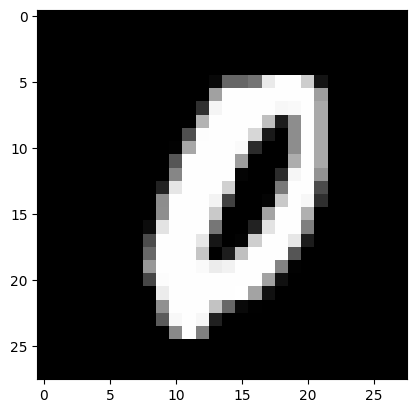

In [21]:
data_loader = load_MNIST(batch=1)
train_loader= data_loader["train"]
img,label = next(iter(train_loader))
print("img:",type(img), img.size(), img.dtype)
print("label:", type(label), label.size(), label.dtype)
print("\t",label, )
plt.imshow(img.view(-1,28), cmap='gray')

0~9の数字があるので，全部で10クラスの分類を行います．

### CNNクラス

PyTorchを使って実装するならば，これまで考えてきた難しいアーキテクチャのことは一度忘れて，ブロックを重ねるようにネットワークを作ることができます．ただし，MLPとは異なり，レイヤーを通った後のテンソルの形状がわかりにくいことに注意してください．

例えば，畳み込み→プーリング→畳み込み→プーリング→MLP のようなネットワークの場合，入力されたテンソルには以下のような形状の変化が起こります．

In [11]:
x = torch.from_numpy(np.random.random([64,1,28,28]).astype(np.float32))
print(x.shape)
y = nn.Conv2d(1,32 ,3,1)(x) # 第一引数（入力チャネル数）を決め打ちしておかないといけない
print(y.shape)
y = nn.MaxPool2d(2,2)(y)
print(y.shape)
y = nn.Conv2d(32,64, 3,1)(y)
print(y.shape)
y = nn.MaxPool2d(2,2)(y)
print(y.shape)
y = nn.Flatten()(y)
print(y.shape)
y = nn.Linear(1600,10) # 第一引数を決めうちしておかないといけない．

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 32, 13, 13])
torch.Size([64, 64, 11, 11])
torch.Size([64, 64, 5, 5])
torch.Size([64, 1600])


入力画像を最初に適用するnn.Conv2dの第一引数と，畳み込みやプーリングを繰り返した後にnn.Flattenした際の特徴数の計算が難しそうです．
以下のような関数でConv層の出力する画像の縦横サイズを求められるので，使ってみてください．

In [12]:
def get_output_shape(
        height:int, 
        padding:int,
        kernel_size:int, 
        stride:int,
        )->int: 
    new_height = (height+2*padding-kernel_size)/stride + 1
    return int(np.floor(new_height))

h = get_output_shape(28,0,3,1)
print(h)
h = get_output_shape(h, 0, 2,2)
print(h)
h = get_output_shape(h,0,3,1)
print(h)
h = get_output_shape(h,0,2,2)
print(h)

26
13
11
5


では，単純なCNNをnn.Sequentialで作成します．

In [13]:
def build_cnn(in_channels:int=1, n_classes:int=10):
    """
    28*28の画像だけ受け付ける
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, # 入力されるチャネル数
                  32, # 出力したいチャネル数
                  3, # カーネルサイズ
                  1, # ストライド
                  0, # パディング
                  ), 
        nn.ReLU(),
        nn.MaxPool2d(2, # カーネルサイズ 
                     2, # ストライド
                     ),
        nn.Conv2d(32,64, 3, 1, 0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),               
        nn.Dropout2d(0.25),
        nn.Flatten(),
        nn.Linear(64*5*5,128),
        nn.ReLU(),
        nn.Linear(128,n_classes)
    )

cnn = build_cnn(3)
x = torch.from_numpy(np.random.random([64,3,28,28]).astype(np.float32))
cnn(x).shape

torch.Size([64, 10])

また，テンソルの形状を考えるのが面倒な場合は，以下のような`LazyHogehoge`（nn.LazyConv2d, nn.LazyLinearなど）を使うことで入力チャネルや入力特徴数の計算を省けます．

In [14]:
def build_lazy_cnn(n_classes:int=10):
    """
    28*28の画像だけ受け付ける
    """
    return nn.Sequential(
        nn.LazyConv2d(#in_channels, # 入力されるチャネル数
                  32, # 出力したいチャネル数
                  3, # カーネルサイズ
                  1, # ストライド
                  0, # パディング
                  ), 
        nn.ReLU(),
        nn.MaxPool2d(2, # カーネルサイズ 
                     2, # ストライド
                     ),
        nn.Conv2d(32,64, 3, 1, 0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),               
        nn.Dropout2d(0.25),
        nn.Flatten(),
        nn.LazyLinear(128),
        nn.ReLU(),
        nn.Linear(128,n_classes)
    )

# 例1
_cnn = build_lazy_cnn(10)
x = torch.from_numpy(np.random.random([64,4,15,15]).astype(np.float32))
print(x.shape, "->", _cnn(x).shape)
# 例2
_cnn = build_lazy_cnn(10)
x = torch.from_numpy(np.random.random([64,3,53,53]).astype(np.float32))
print(x.shape, "->", _cnn(x).shape)

torch.Size([64, 4, 15, 15]) -> torch.Size([64, 10])
torch.Size([64, 3, 53, 53]) -> torch.Size([64, 10])


/Users/mriki/.pyenv/versions/miniforge3-4.10.3-10/envs/datasci/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 学習スクリプト

ここまで来ればMLPと同じような学習スクリプトで訓練することができます．

In [26]:
## ハイパーパラメータなどの設定

#エポック数，バッジサイズ
max_epochs = 20
batch_size = 64

#データのロード
data_loader = load_MNIST(batch=batch_size)

#GPUが使えるときは使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#ネットワーク構造の構築
net = build_cnn(1,10)
print(net)

cpu
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout2d(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=10, bias=True)
)


#### skorchを使った簡易版

以下のコードは[こちら](https://medium.datadriveninvestor.com/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7)を参考にしました．

In [25]:
import skorch
from skorch import NeuralNetClassifier

trainer = NeuralNetClassifier(
    net, 
    max_epochs=max_epochs,
    batch_size=batch_size,
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer= torch.optim.Adam,
    device=device,
)
train_dataset = data_loader["train_dataset"]
y_train = np.array([y for x, y in iter(train_dataset)])
trainer.fit(train_dataset, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0525       0.9059        0.3215  16.3398
      2        0.7644       0.9148        0.2836  16.0602
      3        0.7228       0.9223        0.2617  16.6035
      4        0.3038       0.9558        0.1419  16.4843
      5        0.2049       0.9608        0.1253  16.2570
      6        0.1806       0.9677        0.1039  17.0721
      7        0.1697       0.9625        0.1283  16.4820
      8        0.1639       0.9656        0.1134  16.3160
      9        0.1609       0.9668        0.1057  19.1031
     10        0.1534       0.9715        0.0964  20.2976
     11        0.1516       0.9702        0.1028  25.9277
     12        0.1481       0.9711        0.1010  39.3084
     13        0.1430       0.9701        0.0971  37.3963
     14        0.1416       0.9736        0.0956  31.9419
     15        0.1390       0.9720        0.0955  25.4344
     16       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1600, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=10, bias=True)
  ),
)

::::{margin}

:::{note}
学習したtrainerの保存をする場合：
```python
# saving
with open('some-file.pkl', 'wb') as f:
    pickle.dump(trainer, f)
```
保存されたtrainerを読み込む場合：
```
# loading
with open('some-file.pkl', 'rb') as f:
    trainer = pickle.load(f)
````
:::
::::

Text(0.5, 0.98, 'training history')

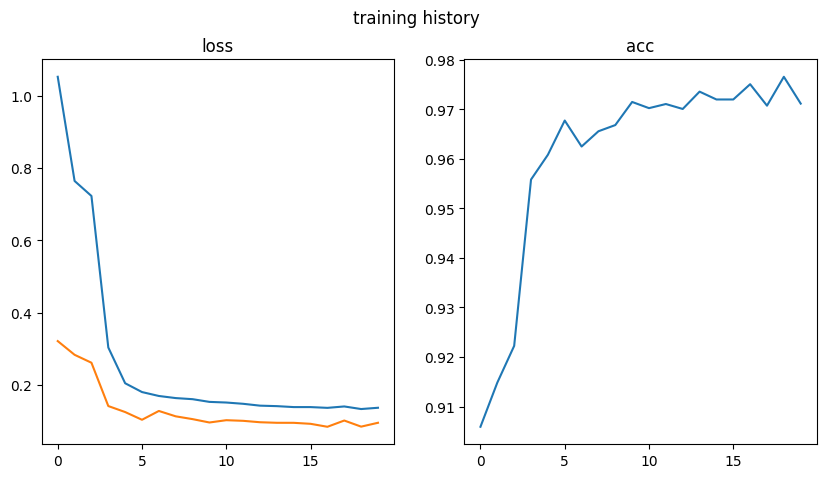

In [36]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(1,2,1)
ax.set_title("loss")
ax.plot(trainer.history[:,"train_loss"], label="train_loss")
ax.plot(trainer.history[:,"valid_loss"], label="valid_loss")

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("acc")
ax2.plot(trainer.history[:,"valid_acc"], label="valid_acc")
fig.suptitle("training history")

#### フルスクラッチ

In [15]:
cnn = cnn.to(device)

#学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": []
}

#最適化方法の設定
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cpu
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout2d(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=10, bias=True)
)


::::{margin}
:::{note}

モデルの保存をする場合は以下のコードを利用します．

```python
PATH = "./my_mnist_model.pt"
torch.save(net.state_dict(), PATH)
````

:::
::::

学習コードです．

In [22]:
for epoch in range(max_epochs):
    # training step
    loss = None
    train_loss = 0.0
    net.train()
    print("\nTrain start")
    for i,(x,y) in enumerate(data_loader["train"]):
        x,y = x.to(device),y.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 順伝搬 -> 逆伝搬 -> 最適化
        output = net(x)
        loss = criterion(output, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        # 途中経過の表示
        if (i+1) % 100 == 0:
            print("Training: {} epoch. {} iteration. Loss:{}".format(epoch+1,i+1,loss.item()))
    train_loss /= len(data_loader["train"])
    print("Training loss (ave.): {}".format(train_loss))
    history["train_loss"].append(train_loss)

    """validation step"""
    print("\nValidation start")
    net.eval()
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for x,y in data_loader["validation"]:
            x,y = x.to(device),y.to(device)

            output = net(x)
            val_loss = criterion(output,y)
            pred_y = output.argmax(dim=1,keepdim=True)
            accuracy += pred_y.eq(y.view_as(pred_y)).sum().item()

    val_loss /= len(data_loader["validation"])
    accuracy /= len(data_loader["validation"].dataset)

    print("Validation loss: {}, Accuracy: {}\n".format(val_loss,accuracy))
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(accuracy)


Train start
Training: 1 epoch. 100 iteration. Loss:0.37115180492401123
Training: 1 epoch. 200 iteration. Loss:0.17168577015399933
Training: 1 epoch. 300 iteration. Loss:0.19651196897029877
Training: 1 epoch. 400 iteration. Loss:0.1328047811985016
Training: 1 epoch. 500 iteration. Loss:0.10174187272787094
Training: 1 epoch. 600 iteration. Loss:0.1402805894613266


KeyboardInterrupt: 

## 課題

[課題1] このノートではmnistデータセットのクラス分類を行うCNNを実装しました．これを主要なパラメータをCLIのオプションで変更できる形にしたプログラムcnn_mnist.pyを作成してください．

:::{hint}   
MLPやw2vの実装を参考にしながら，必要なハイパーパラメータやモデルの保存場所などを変更できるようなCLIのオプション（引数）を用意してください．（多分正解はない）

:::

[課題2] CIFAR-10データセットのクラス分類を行うCNNを実装して，訓練とテストデータによる評価までを行うプログラムcnn_cifar10.pyを作成してください．主要なパラメータをCLIのオプションで変更できるようにすること．また，できるだけテスト正解率が高くなるようにモデルをチューニングして，デフォルトの引数として設定すること．

:::{hint}   
テストデータに対する正答率が高くなるようにチューニングするように求められていますが，テストデータは基本的に一番最後にだけ利用します．つまり代用として教師データから任意の割合で切り出したバリデーションデータをテストデータとして利用し，バリデーションデータに対する正答率が高くなるようにチューニングをします．その後，課題を提出する段階になったら本物のテストデータに対する正答率を求めてください．   
:::

## 参考文献


```{bibliography}
:filter: docname in docnames
```